In [1]:
# imports and stuff
import os
os.chdir('../..')  # we're in $CAFFE_ROOT/examples/swwae
import sys
sys.path.insert(0, './python')
import caffe
from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2
from pylab import *
%matplotlib inline

In [2]:
# set up solver
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/swwae/solver.prototxt')

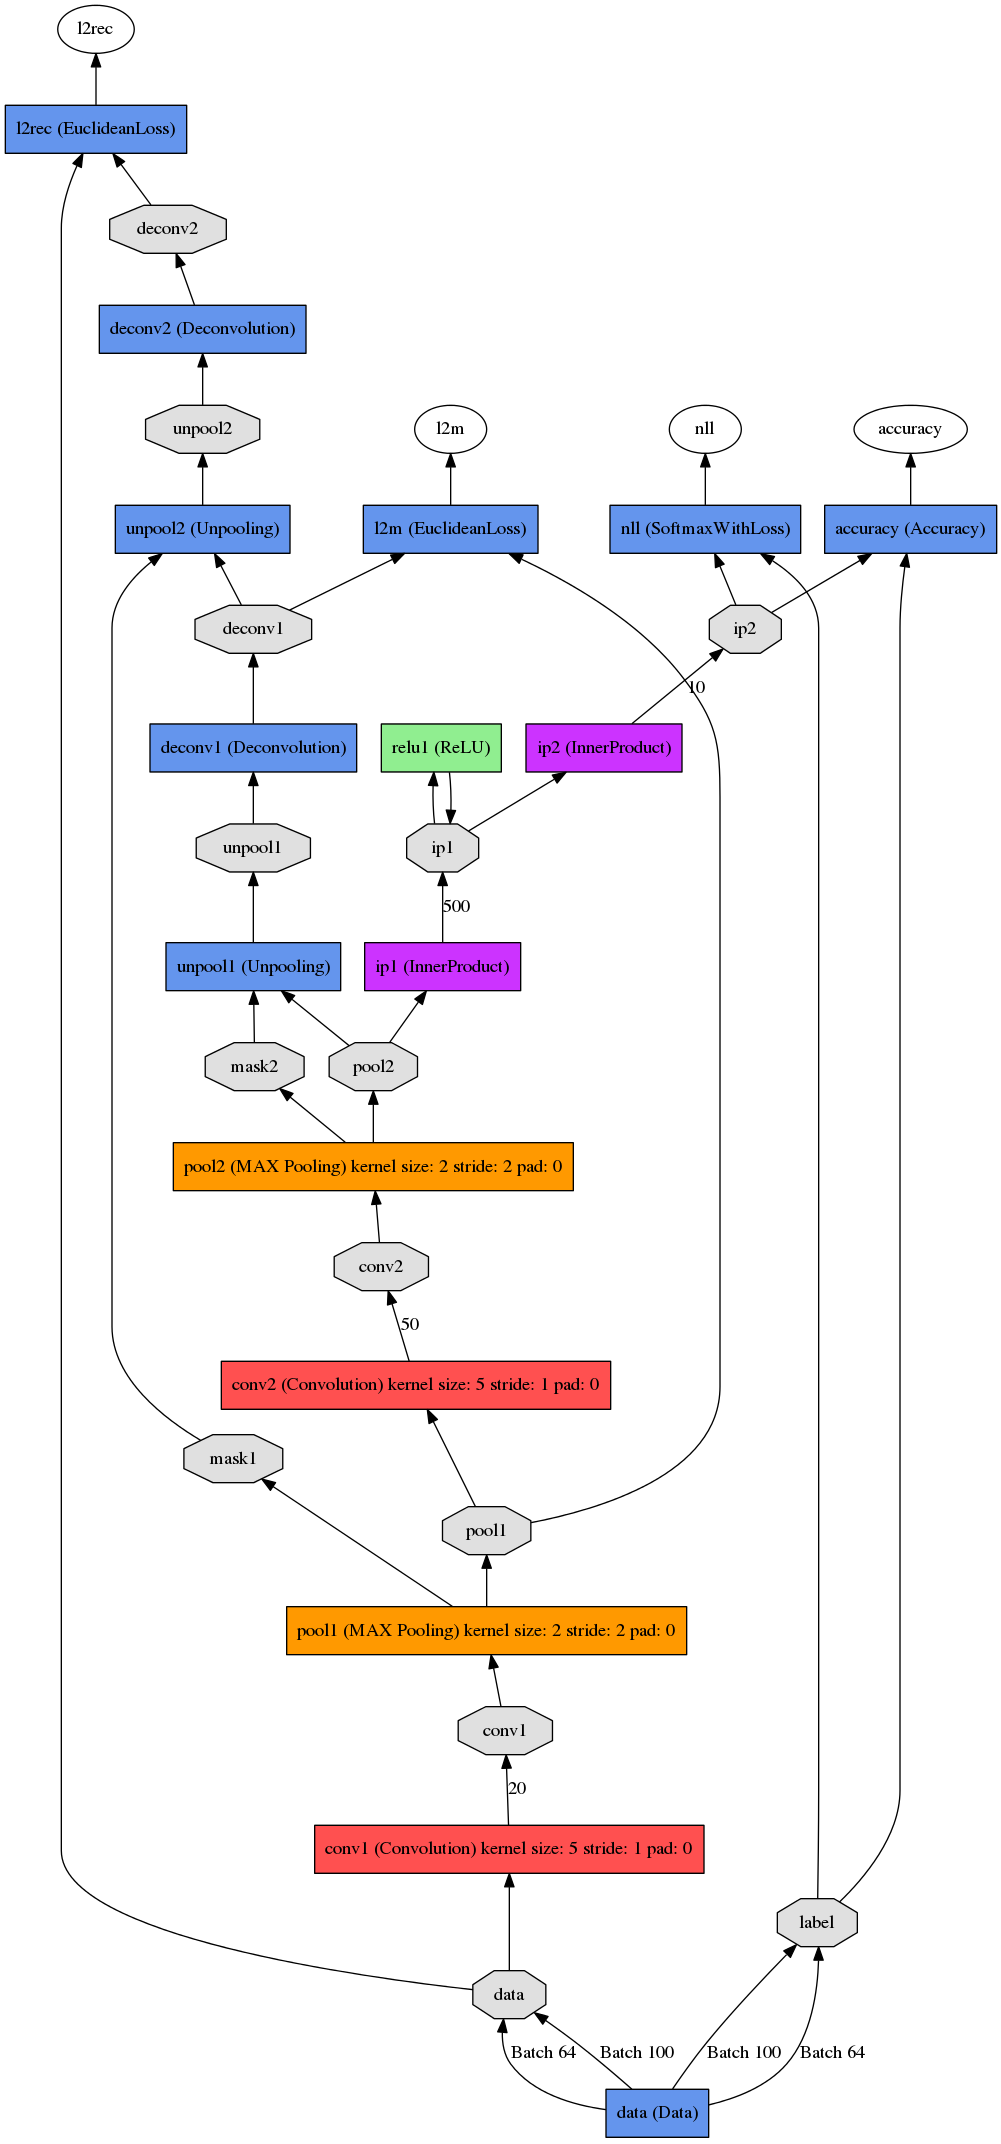

In [3]:
# draw and display the net
from IPython.display import Image
net = caffe_pb2.NetParameter()
text_format.Merge(open('examples/swwae/train.prototxt').read(), net)
caffe.draw.draw_net_to_file(net, 'examples/swwae/net_figure.png', 'BT')

Image(filename='examples/swwae/net_figure.png')

In [4]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('data_data_0_split_0', (64, 1, 28, 28)),
 ('data_data_0_split_1', (64, 1, 28, 28)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('mask1', (64, 20, 12, 12)),
 ('pool1_pool1_0_split_0', (64, 20, 12, 12)),
 ('pool1_pool1_0_split_1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('mask2', (64, 50, 4, 4)),
 ('pool2_pool2_0_split_0', (64, 50, 4, 4)),
 ('pool2_pool2_0_split_1', (64, 50, 4, 4)),
 ('unpool1', (64, 50, 8, 8)),
 ('deconv1', (64, 20, 12, 12)),
 ('deconv1_deconv1_0_split_0', (64, 20, 12, 12)),
 ('deconv1_deconv1_0_split_1', (64, 20, 12, 12)),
 ('unpool2', (64, 20, 24, 24)),
 ('deconv2', (64, 1, 28, 28)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('nll', ()),
 ('l2rec', ()),
 ('l2m', ())]

In [10]:
# run training
niter = 1000000
test_interval = 100
train_loss = zeros(niter)
reconstr_loss = zeros(niter)
intermediate_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['nll'].data
    reconstr_loss[it] = solver.net.blobs['l2rec'].data
    intermediate_loss[it] = solver.net.blobs['l2m'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
        print 'nll: ', train_loss[it], ' l2rec: ', reconstr_loss[it], ' l2m: ', intermediate_loss[it]

Iteration 0 testing...
nll:  0.047188937664  l2rec:  486.87387085  l2m:  769.912719727
Iteration 100 testing...
nll:  0.19642958045  l2rec:  502.068878174  l2m:  807.160217285
Iteration 200 testing...
nll:  0.109456487  l2rec:  476.811218262  l2m:  785.608764648
Iteration 300 testing...
nll:  0.0770678818226  l2rec:  457.06741333  l2m:  737.559509277
Iteration 400 testing...
nll:  0.112734511495  l2rec:  481.000152588  l2m:  786.051818848
Iteration 500 testing...
nll:  0.188445597887  l2rec:  481.15057373  l2m:  794.527587891
Iteration 600 testing...
nll:  0.0534595102072  l2rec:  408.276245117  l2m:  689.807983398
Iteration 700 testing...
nll:  0.00949282385409  l2rec:  487.726135254  l2m:  801.172912598
Iteration 800 testing...
nll:  0.0240728650242  l2rec:  550.628356934  l2m:  898.135314941
Iteration 900 testing...
nll:  0.0857753753662  l2rec:  485.668731689  l2m:  822.770751953
Iteration 1000 testing...
nll:  0.00593849970028  l2rec:  540.131591797  l2m:  915.169433594
Iteration 

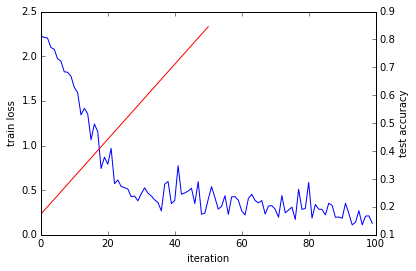

In [6]:
# plot progress
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

In [36]:
#imshow(solver.net.params['deconv1'][0].diff[:, 0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')
imshow(solver.net.params['deconv1'][0].data[0:9, 0].reshape(3, 3, 5, 5).transpose(0, 2, 1, 3).reshape(3*3, 3*3), cmap='gray')

ValueError: axes don't match array

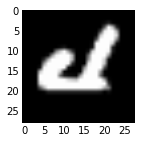

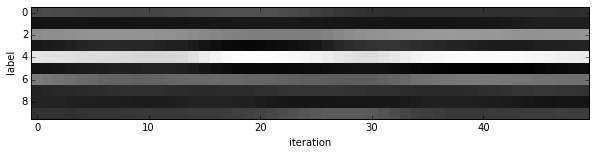

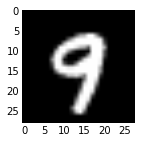

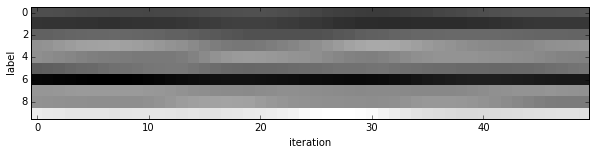

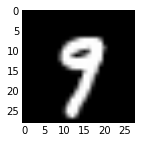

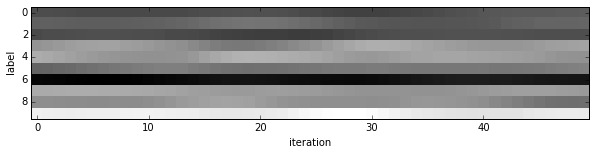

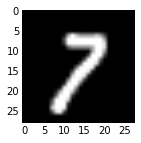

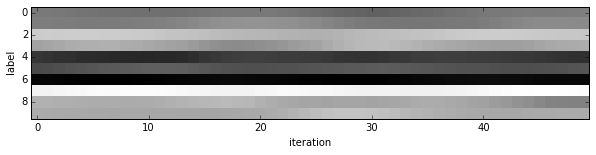

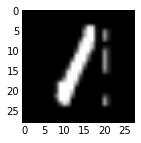

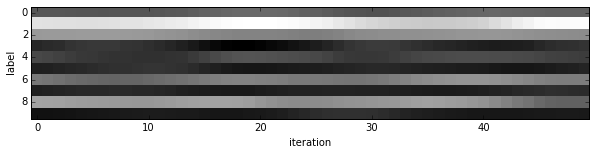

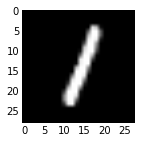

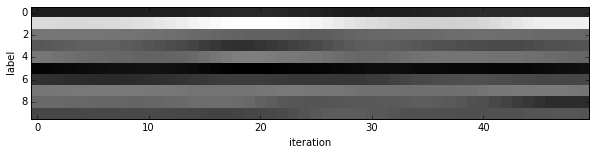

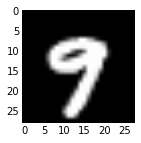

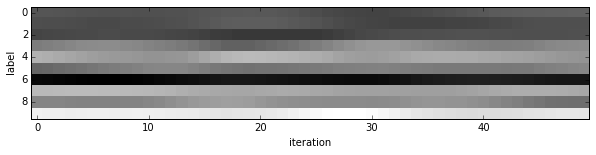

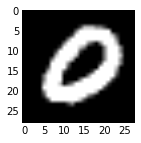

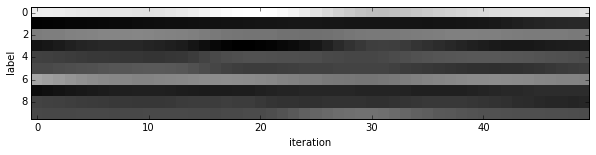

In [11]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')